# BUFN403 Financial Statement Analysis Spring 2024

Code from the previous semester. Used as reference or inspiration for the Spring 2025 class.

## Instructions

Use FinBERT Topic Modeling to determine the topic mix for each document over the 20 financial topics. This will provide a 20 dimensional vector with a binary value for the presence (1) or absence (0) of each topic.
Use FinBERT and / or VADER to obtain sentiment score(s). 
A “mystery” indicator has been provided.
You can use LDA Topic Modeling or other tools to obtain more features.
You can use derived features, e.g., the count of the 20 topics that are present in some financial statement, moments, etc.

Use Linear Regression (or similar) for analysis. 
The independent variables include the presence / absence of a topic and the sentiment score(s). 
Use PRICE instead.
The model should consider the independent variables for the company in Year t to predict the (change in the) outcome variable, e.g., the change in EBITDA PRICE between Year(t) and Year (t+1). shift(1) in pandas may be useful.

## Loading all the necessary libraries

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
import os
import warnings

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.set_theme(style="whitegrid")

warnings.filterwarnings("ignore")

## Loading the CSV files

Consider the following corpus of quarterly earnings reports (transcripts) from 25 companies in the S&P 500 index; the dataset covers the period 2017-2021.
https://drive.google.com/drive/folders/1e_FpIjoKTHNNUHl-HBCKHnhMGUVODc2U?usp=sharing

Note: For each company / quarter there are multiple entries ( multiple speakers). In a few cases, the ‘text’ entries have been duplicated. Use drop_duplicates or similar using the ‘text’ column.
Note: The dataset with topics is here:
https://drive.google.com/drive/folders/1doNnC-it4jDmieufcBA7C4SjtObrgxEd
Topics are comma separated in Column L. Ignore Column M.


In [13]:
# This function loads the CSV using the filepath and drops the duplicate rows based on the text column
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates(subset=["text"])

    return df


# Apply the load_data to all CSV files
listed_companies = [
    "AAPL", "AMZN", "AZO", "BA", "BMY", "BSX", "CBRE", "CI", "DHI", "EMN", 
    "FDX", "GPN", "HAL", "JNPR", "KO", "MCO", "MKTX", "NVDA", "PFG", "RL", "TGT"
]

# Dictionary containing all the dataframes for each company csv
all_companies_df = {
    ticker: load_data(f"data/{ticker}_2017_2021_v2.csv") for ticker in listed_companies
}

# Example data loading for AAPL
AAPL_df = load_data("data/AAPL_2017_2021_v2.csv")
AAPL_df

,id,sequence,label,date,quarter,year,speaker,title,text,mystery indicator,VADER sentiment
0,AAPL-2020-Q1-2020-01-28,5,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury","Thank you. Good afternoon, and thank you for j...",0.140482,0.785
2,AAPL-2020-Q1-2020-01-28,7,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury",Please note that some of the information you'l...,0.286783,0.288
4,AAPL-2020-Q1-2020-01-28,9,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury",I'd now like to turn the call over to Tim for ...,0.510806,0.361
6,AAPL-2020-Q1-2020-01-28,11,Remarks,2020-01-28,1,2020,Timothy Donald Cook,Chief Executive Officer & Director,"Thanks, Tejas. Good afternoon, and thanks to a...",1.168873,0.827
8,AAPL-2020-Q1-2020-01-28,13,Remarks,2020-01-28,1,2020,Timothy Donald Cook,Chief Executive Officer & Director,We're thrilled to report Apple's biggest quart...,0.078219,0.863
...,...,...,...,...,...,...,...,...,...,...,...
3636,AAPL-2017-Q2-2017-05-02,217,Question,2017-05-02,2,2017,Simona Jankowski,Goldman Sachs,"Thank you, and then just for Tim. Tim, you've ...",0.062295,0.756
3638,AAPL-2017-Q2-2017-05-02,227,Question,2017-05-02,2,2017,Jim Suva,Citigroup,Thank you very much and congratulations on ret...,0.308704,0.959
3640,AAPL-2017-Q2-2017-05-02,233,Question,2017-05-02,2,2017,Jim Suva,Citigroup,"Great, thanks so much for the detail. That's g...",0.181014,0.891
3642,AAPL-2017-Q2-2017-05-02,237,Answer,2017-05-02,2,2017,Nancy Paxton,Investor Relations Contact,"Thank you, Jim. A replay of today's call will ...",0.464937,0.586


In [14]:
all_companies_df.keys()

dict_keys(['AAPL', 'AMZN', 'AZO', 'BA', 'BMY', 'BSX', 'CBRE', 'CI', 'DHI', 'EMN', 'FDX', 'GPN', 'HAL', 'JNPR', 'KO', 'MCO', 'MKTX', 'NVDA', 'PFG', 'RL', 'TGT'])

In the below cell, we use the apply method on df to calculate the average stock price for each row based on the company_ticker and year, storing the result in a new column named avg_price. This step leverages the get_price function. Then,  we calculate the year-over-year price change for each stock ticker. This is achieved by grouping the DataFrame by company_ticker and then applying the diff method on the avg_price column to get the difference in average price between consecutive years. The result is stored in a new column named price_change, which is the outcome variable that we are trying to predict.

In [15]:
folder_path = './data'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dataframes = [pd.read_csv(folder_path + '/' + file_name) for file_name in csv_files]
df_combined = pd.concat(dataframes, ignore_index=True)
df_combined.drop_duplicates(subset=['text'], inplace=True)
df = df_combined.sample(n=2000, random_state=42)

# method to get ticker from id
def extract_ticker(id_str):
    return id_str.split('-')[0]


df['company_ticker'] = df['id'].apply(extract_ticker)


# method to get price for that ticker, and gets the average of it, and reports that as the stock price
def get_price(ticker, year):
    print(ticker, year)
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="max")
        yearly_prices = hist.loc[hist.index.year == year, 'Close']
        if not yearly_prices.empty:
            avg_price = yearly_prices.mean()
            return avg_price
        else:
            return None
    except Exception as e:
        print(f"Error retrieving price for {ticker}: {e}")
        return None

# type checking, and updating
df['year'] = df['year'].astype(int)
df['avg_price'] = df.apply(lambda x: get_price(x['company_ticker'], x['year']), axis=1)

df.sort_values(by=['company_ticker', 'year'], inplace=True)
df['price_change'] = df.groupby('company_ticker')['avg_price'].diff()

display(df[['company_ticker', 'year', 'avg_price', 'price_change']])


$TGT: possibly delisted; no price data found  (1d 1926-02-20 -> 2025-01-26)


Error retrieving price for TGT: 'Index' object has no attribute 'year'


$KO: possibly delisted; no price data found  (1d 1926-02-20 -> 2025-01-26)


Error retrieving price for KO: 'Index' object has no attribute 'year'


$DHI: possibly delisted; no price data found  (1d 1926-02-20 -> 2025-01-26)


Error retrieving price for DHI: 'Index' object has no attribute 'year'


,company_ticker,year,avg_price,price_change
12029,AAPL,2017,35.172489,NaN
11033,AAPL,2017,35.172490,9.574738e-07
11977,AAPL,2017,35.172490,-3.115589e-07
9479,AAPL,2017,35.172490,9.878698e-08
10963,AAPL,2017,35.172490,2.659649e-07
...,...,...,...,...
3833,TGT,2021,206.351340,1.150464e-06
3034,TGT,2021,206.351341,4.844060e-07
4356,TGT,2021,206.351340,-9.082613e-07
3837,TGT,2021,206.351338,-1.332117e-06


In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# method to bin everything
def bin_price_change(x):
    # Not these cut offs are arbitrary, and can be modified
    if x > 10:
        return 'Significant gain'
    elif x > 1:
        return 'Moderate gain'
    elif x > -1:
        return 'No change'
    elif x > -10:
        return 'Moderate loss'
    else:
        return 'Significant loss'

# getting price change
df['price_change_category'] = df['price_change'].apply(bin_price_change)

# see distribution
category_counts = df['price_change_category'].value_counts()

print(category_counts)

price_change_category
No change           1881
Significant gain      47
Significant loss      35
Moderate gain         26
Moderate loss         11
Name: count, dtype: int64


## Loading the HuggingFace models for topic classification

BERT is a well known transformer based approach for a Large Language Model (LLM). FinBERT has been trained on financial documents and can provide a sentiment score. VADER is another tool that can provide a sentiment score.

This code was given in the document provided.

In this step, we are initializing the finbert tokenizer and the model for text classification. 

In [48]:
"""
Store the best topic (highest softmax score) for each text row
"""
tokenizer = AutoTokenizer.from_pretrained("nickmuchi/finbert-tone-finetuned-finance-topic-classification", 
                                          token='')

model = AutoModelForSequenceClassification.from_pretrained("nickmuchi/finbert-tone-finetuned-finance-topic-classification", 
                                                           token='')

topics = {
   0: "Analyst Update",
   1: "Fed | Central Banks",
   2: "Company | Product News",
   3: "Treasuries | Corporate Debt",
   4: "Dividend",
   5: "Earnings",
   6: "Energy | Oil",
   7: "Financials",
   8: "Currencies",
   9: "General News | Opinion",
   10: "Gold | Metals | Materials",
   11: "IPO",
   12: "Legal | Regulation",
   13: "M&A | Investments",
   14: "Macro",
   15: "Markets",
   16: "Politics",
   17: "Personnel Change",
   18: "Stock Commentary",
   19: "Stock Movement",
}


In this step, we are developing the pipeline from the text column to be process by the finbert model. It tokenizes the texts and returns a score for the text classifcation which is then put into softmax for multi class classification to determine the optimal topic. This is applied to all companies. For reference, I printed out the first 10 rows of AAPL.

In [25]:
finbert_pipeline = pipeline("text-classification", 
                            model=model, 
                            tokenizer=tokenizer, 
                            return_all_scores=True)

# Classifies that text in a series or list
# Uses torch softmax from the evaluations in finbert
def classify_text(text):
    results = finbert_pipeline(text)

    processed_results = []

    for result in results:
        scores = torch.softmax(torch.tensor([score["score"] for score in result]), dim=0)

        best_topics_idx = torch.argmax(scores).item()
        processed_results.append(topics[best_topics_idx])

    return processed_results

all_companies_text_class = {}

# Apply the function to all the companies to get text classificatons
for company_name in all_companies_df:
    text = all_companies_df[company_name]["text"][:10].tolist()
    
    all_companies_text_class[company_name] = classify_text(text)


# Only processing the first 10
AAPL_texts = AAPL_df["text"][:10].tolist()
classified_topics = classify_text(AAPL_texts)

for text, topic in zip(AAPL_texts, classified_topics):
    print("Text:", text)
    print("Topic:", topic)

Device set to use mps:0


Text: Thank you. Good afternoon, and thank you for joining us. Speaking first today is Apple's CEO, Tim Cook, and he'll be followed by CFO, Luca Maestri. After that, we'll open the call to questions from analysts.
Topic: Company | Product News
Text: Please note that some of the information you'll hear during our discussion today will consist of forward-looking statements, including without limitation, those regarding revenue, gross margin, operating expenses, other income and expenses, taxes, capital allocation and future business outlook. Actual results or trends could differ materially from our forecast. For more information, please refer to the risk factors discussed in Apple's most recently filed periodic reports on Form 10-K and Form 10-Q and the Form 8-K filed with the SEC today, along with the associated press release. Apple assumes no obligation to update any forward-looking statements or information, which speaks as of their respective dates.
Topic: Company | Product News
Text

<Axes: >

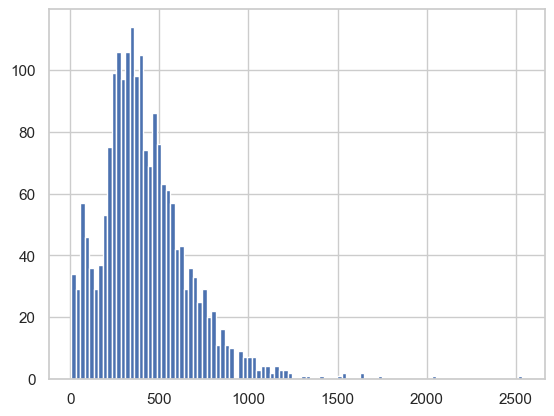

In [84]:
df.text.str.len().hist(bins=100)

In [24]:
all_companies_text_class["AMZN"]

['Earnings',
 'Earnings',
 'Earnings',
 'Financials',
 'Financials',
 'General News | Opinion',
 'General News | Opinion',
 'Company | Product News',
 'Company | Product News',
 'Stock Commentary']

In [34]:
### Important for Macbooks using M-series chip!!!
print(f"MPS available: {torch.backends.mps.is_available()}")

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
model = model.to(device)

MPS available: True
Using device: mps


In [36]:
def extract_topic(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return topics[predicted_class]

# Apply the function to the DataFrame
df['extracted_topics'] = df['text'].apply(extract_topic)

# Display the resulting DataFrame
print(df[['text', 'extracted_topics']])

                                                    text  \
12029  On Qualcomm, I just want to make it very, very...   
11033  The other thing that's happened is that the de...   
11977  For details by product, I'll start with iPhone...   
9479   Thank you, and maybe a question for both Tim a...   
10963  Moving on now to Apple Watch. With unit growth...   
...                                                  ...   
3833   Good Morning, Paul. It's good to talk to you. ...   
3034   promote opportunity and equity in our communit...   
4356   Our confidence in Target's ability to continue...   
3837   So our guests absolutely love that and you'll ...   
4578   Over the past few years, between our propertie...   

             extracted_topics  
12029  Company | Product News  
11033  General News | Opinion  
11977  Company | Product News  
9479   General News | Opinion  
10963  Company | Product News  
...                       ...  
3833   General News | Opinion  
3034   General News | O

In [37]:
# Given code for generating features
topics = df['extracted_topics'].str.get_dummies(sep=',')
company_dummies = pd.get_dummies(df['company_ticker'], prefix='company')

# Ensure 'mystery indicator' and 'VADER sentiment' are not dropped due to NaNs
df['mystery indicator'].fillna(df['mystery indicator'].mean(), inplace=True)
df['VADER sentiment'].fillna(df['VADER sentiment'].mean(), inplace=True)

# pick inpit features
X = pd.concat([topics, df['mystery indicator'], df['VADER sentiment'], company_dummies], axis=1)
X.dropna(axis=1, how='any', inplace=True)
# output features
y = df['price_change_category']

X = X.loc[y.index]

# scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# model training and fitting
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

model.fit(X_train_scaled, y_train)

print('Training accuracy:', model.score(X_train_scaled, y_train))
print('Testing accuracy:', model.score(X_test_scaled, y_test))

feature_names = X.columns
coefficients = model.coef_
class_labels = model.classes_

Training accuracy: 0.943125
Testing accuracy: 0.935


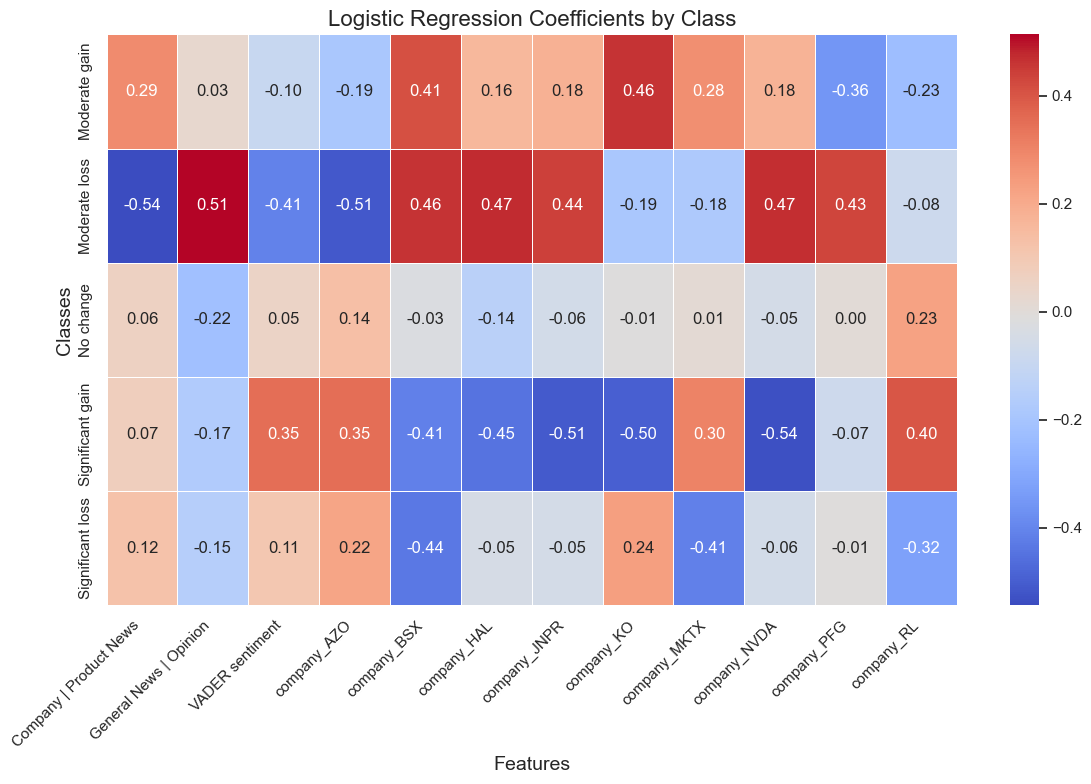

In [47]:
coef_df = pd.DataFrame(coefficients, columns=feature_names, index=class_labels)

# Added a threshold to reduce the numbre of features shown
threshold = 0.4
important_features = coef_df.loc[:, (coef_df.abs() > threshold).any(axis=0)]

# Heatmap 
plt.figure(figsize=(12, 8))
# sns.heatmap(coef_df, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
sns.heatmap(important_features, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Logistic Regression Coefficients by Class', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [41]:
# Top features by class
for index, class_label in enumerate(class_labels):
    print(f"Top 5 features for class '{class_label}':")
    top_features = sorted(zip(feature_names, coefficients[index]), key=lambda x: abs(x[1]), reverse=True)[:5]
    for feature, coef in top_features:
        print(f"{feature}: {coef:.2f}")
    print("\n")

Top 5 features for class 'Moderate gain':
company_KO: 0.46
company_BSX: 0.41
company_TGT: -0.39
company_PFG: -0.36
company_MCO: -0.31


Top 5 features for class 'Moderate loss':
Company | Product News: -0.54
company_AZO: -0.51
General News | Opinion: 0.51
company_HAL: 0.47
company_NVDA: 0.47


Top 5 features for class 'No change':
company_BA: 0.31
company_BMY: -0.23
company_RL: 0.23
General News | Opinion: -0.22
company_DGX: -0.18


Top 5 features for class 'Significant gain':
company_NVDA: -0.54
company_JNPR: -0.51
company_KO: -0.50
company_HAL: -0.45
company_BSX: -0.41


Top 5 features for class 'Significant loss':
company_BSX: -0.44
company_MKTX: -0.41
company_AMZN: -0.34
company_RL: -0.32
company_BA: 0.29




Next, we're doing a sentiment analysis pipeline that also uses the text column and determins a score. This process is similar to the text-classification part. The pipelien will return the sentiment and the score. I also displayed the output for AAPL for reference.

In [49]:
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Since the function is simple, if you want you can just directly call it instead
# I believe this code design makes it more configurable later
def analyze_sentiment(texts):
    results = sentiment_analysis(texts)
    
    return results


all_companies_sentiment_analysis = {}

# Apply the function to all the companies to get sentiment analysis
for company_name in all_companies_df:
    text = all_companies_df[company_name]["text"][:10].tolist()
    
    all_companies_sentiment_analysis[company_name] = analyze_sentiment(text)


# Note: When placing the sentiment scores back, it must be the same dimension as the # of rows
sentiment_results = analyze_sentiment(AAPL_df["text"].tolist())
AAPL_df["Sentiment"] = [result["label"] for result in sentiment_results]
AAPL_df["Sentiment Score"] = [result["score"] for result in sentiment_results]

display(sentiment_results)
display(AAPL_df)

Device set to use mps:0


[{'label': 'Company | Product News', 'score': 0.5114220976829529},
 {'label': 'Company | Product News', 'score': 0.346532940864563},
 {'label': 'General News | Opinion', 'score': 0.7147918343544006},
 {'label': 'General News | Opinion', 'score': 0.7628178000450134},
 {'label': 'Financials', 'score': 0.8582173585891724},
 {'label': 'Financials', 'score': 0.554787814617157},
 {'label': 'Company | Product News', 'score': 0.5749369859695435},
 {'label': 'Financials', 'score': 0.83074951171875},
 {'label': 'Company | Product News', 'score': 0.546497106552124},
 {'label': 'Financials', 'score': 0.8901745676994324},
 {'label': 'Company | Product News', 'score': 0.9442577362060547},
 {'label': 'Company | Product News', 'score': 0.987263023853302},
 {'label': 'Company | Product News', 'score': 0.9939653277397156},
 {'label': 'Company | Product News', 'score': 0.9763692021369934},
 {'label': 'Company | Product News', 'score': 0.993394672870636},
 {'label': 'Company | Product News', 'score': 0.90

,id,sequence,label,date,quarter,year,speaker,title,text,mystery indicator,VADER sentiment,Sentiment,Sentiment Score
0,AAPL-2020-Q1-2020-01-28,5,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury","Thank you. Good afternoon, and thank you for j...",0.140482,0.785,Company | Product News,0.511422
2,AAPL-2020-Q1-2020-01-28,7,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury",Please note that some of the information you'l...,0.286783,0.288,Company | Product News,0.346533
4,AAPL-2020-Q1-2020-01-28,9,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury",I'd now like to turn the call over to Tim for ...,0.510806,0.361,General News | Opinion,0.714792
6,AAPL-2020-Q1-2020-01-28,11,Remarks,2020-01-28,1,2020,Timothy Donald Cook,Chief Executive Officer & Director,"Thanks, Tejas. Good afternoon, and thanks to a...",1.168873,0.827,General News | Opinion,0.762818
8,AAPL-2020-Q1-2020-01-28,13,Remarks,2020-01-28,1,2020,Timothy Donald Cook,Chief Executive Officer & Director,We're thrilled to report Apple's biggest quart...,0.078219,0.863,Financials,0.858217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3636,AAPL-2017-Q2-2017-05-02,217,Question,2017-05-02,2,2017,Simona Jankowski,Goldman Sachs,"Thank you, and then just for Tim. Tim, you've ...",0.062295,0.756,Company | Product News,0.819138
3638,AAPL-2017-Q2-2017-05-02,227,Question,2017-05-02,2,2017,Jim Suva,Citigroup,Thank you very much and congratulations on ret...,0.308704,0.959,Company | Product News,0.637581
3640,AAPL-2017-Q2-2017-05-02,233,Question,2017-05-02,2,2017,Jim Suva,Citigroup,"Great, thanks so much for the detail. That's g...",0.181014,0.891,General News | Opinion,0.745165
3642,AAPL-2017-Q2-2017-05-02,237,Answer,2017-05-02,2,2017,Nancy Paxton,Investor Relations Contact,"Thank you, Jim. A replay of today's call will ...",0.464937,0.586,Earnings,0.627117


The code below is an example of how the sentiment analysis would look for a single company, Apple. I am displaying the relevant columns in order to show how the output is formatted.

In [50]:
# Dataframe to validate output
AAPL_predictions = {
    "id": AAPL_df["id"],
    "VADER": AAPL_df["VADER sentiment"],
    "Sentiment": AAPL_df["Sentiment"],
    "Sentiment Score": AAPL_df["Sentiment Score"]
}

# Convert the dictionary to a dataframe and display
AAPL_predictions = pd.DataFrame(AAPL_predictions)
AAPL_predictions

,id,VADER,Sentiment,Sentiment Score
0,AAPL-2020-Q1-2020-01-28,0.785,Company | Product News,0.511422
2,AAPL-2020-Q1-2020-01-28,0.288,Company | Product News,0.346533
4,AAPL-2020-Q1-2020-01-28,0.361,General News | Opinion,0.714792
6,AAPL-2020-Q1-2020-01-28,0.827,General News | Opinion,0.762818
8,AAPL-2020-Q1-2020-01-28,0.863,Financials,0.858217
...,...,...,...,...
3636,AAPL-2017-Q2-2017-05-02,0.756,Company | Product News,0.819138
3638,AAPL-2017-Q2-2017-05-02,0.959,Company | Product News,0.637581
3640,AAPL-2017-Q2-2017-05-02,0.891,General News | Opinion,0.745165
3642,AAPL-2017-Q2-2017-05-02,0.586,Earnings,0.627117


The code below is provided in the assignment outline document.

In [51]:
def get_gaap_earnings(ticker): 
    try: 
        # Create a Ticker object for the specified stock 
        stock = yf.Ticker(ticker) 
        # Get the financial data 
        financials = stock.financials.loc['Net Income'] 
        # Get the most recent GAAP earnings 
        gaap_earnings = financials.iloc[-1] 
        return gaap_earnings 
    except Exception as e: 
        print(f"Error retrieving GAAP earnings for {ticker}: {e}") 
        return None 

# Example usage 
ticker_symbol = "AAPL" # Apple Inc. 
gaap_earnings = get_gaap_earnings(ticker_symbol)
 
if gaap_earnings is not None: 
    print(f"The GAAP earnings for {ticker_symbol} is: {gaap_earnings}")


The GAAP earnings for AAPL is: nan


<b>Instructions for this step</b>

Use Linear Regression (or similar) for analysis. 
The independent variables include the presence / absence of a topic and the sentiment score(s). 
Use PRICE instead.
The model should consider the independent variables for the company in Year t to predict the (change in the) outcome variable, e.g., the change in EBITDA PRICE between Year(t) and Year (t+1). shift(1) in pandas may be useful.

In [59]:
all_companies_df["AAPL"].columns

Index(['id', 'sequence', 'label', 'date', 'quarter', 'year', 'speaker',
       'title', 'text', 'mystery indicator', 'VADER sentiment'],
      dtype='object')

In [ ]:
import pandas as pd
import yfinance as yf

# Iterate through all companies in all_companies_df
for company_name in all_companies_df:
    # Download data and reset index
    yf_data = yf.download(company_name, start="2020-01-01", end="2021-01-01")
    yf_data = yf_data.reset_index()

    # Flatten MultiIndex columns if needed
    if isinstance(yf_data.columns, pd.MultiIndex):
        yf_data.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in yf_data.columns]

    # Format the Date column for merging
    yf_data["Date"] = yf_data["Date"].dt.strftime("%Y-%m-%d")

    # Dynamically select the "Close" column relevant to the company
    close_col = [col for col in yf_data.columns if "Close" in col and company_name in col]
    if not close_col:
        raise ValueError(f"No 'Close' column found for {company_name} in the downloaded data.")
    close_col = close_col[0]

    # Merge data into all_companies_df
    all_companies_df[company_name] = pd.merge(
        all_companies_df[company_name],
        yf_data[["Date", close_col]],
        how="left",
        left_on="date",
        right_on="Date"
    )

    # Rename the "Close" column for consistency
    all_companies_df[company_name].rename(columns={close_col: "Close"}, inplace=True)

    # Fill missing values in the "Close" column
    all_companies_df[company_name]["Close"] = all_companies_df[company_name]["Close"].ffill()
    all_companies_df[company_name]["Close"] = all_companies_df[company_name]["Close"].bfill()
    all_companies_df[company_name] = all_companies_df[company_name].dropna()

# Example for AAPL specifically (if needed separately)
yf_AAPL_data = yf.download("AAPL", start="2020-01-01", end="2021-01-01")
yf_AAPL_data = yf_AAPL_data.reset_index()

# Flatten MultiIndex columns if needed
if isinstance(yf_AAPL_data.columns, pd.MultiIndex):
    yf_AAPL_data.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in yf_AAPL_data.columns]

# Format the Date column
yf_AAPL_data["Date"] = yf_AAPL_data["Date"].dt.strftime("%Y-%m-%d")

# Dynamically find the "Close" column for AAPL
close_col = [col for col in yf_AAPL_data.columns if "Close" in col and "AAPL" in col]
if not close_col:
    raise ValueError("No 'Close' column found for AAPL in the downloaded data.")
close_col = close_col[0]

# Merge AAPL data into AAPL_df
AAPL_df = pd.merge(
    AAPL_df,
    yf_AAPL_data[["Date", close_col]],
    how="left",
    left_on="date",
    right_on="Date"
)

# Rename and fill missing values
AAPL_df.rename(columns={close_col: "Close"}, inplace=True)
AAPL_df["Close"] = AAPL_df["Close"].ffill()
AAPL_df["Close"] = AAPL_df["Close"].bfill()

In [70]:
display(AAPL_df)

,id,sequence,label,date,quarter,year,speaker,title,text,mystery indicator,VADER sentiment,Sentiment,Sentiment Score,Date,Close
0,AAPL-2020-Q1-2020-01-28,5,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury","Thank you. Good afternoon, and thank you for j...",0.140482,0.785,Company | Product News,0.511422,2020-01-28,76.998726
1,AAPL-2020-Q1-2020-01-28,7,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury",Please note that some of the information you'l...,0.286783,0.288,Company | Product News,0.346533,2020-01-28,76.998726
2,AAPL-2020-Q1-2020-01-28,9,Remarks,2020-01-28,1,2020,Tejas Gala,"Director, Treasury",I'd now like to turn the call over to Tim for ...,0.510806,0.361,General News | Opinion,0.714792,2020-01-28,76.998726
3,AAPL-2020-Q1-2020-01-28,11,Remarks,2020-01-28,1,2020,Timothy Donald Cook,Chief Executive Officer & Director,"Thanks, Tejas. Good afternoon, and thanks to a...",1.168873,0.827,General News | Opinion,0.762818,2020-01-28,76.998726
4,AAPL-2020-Q1-2020-01-28,13,Remarks,2020-01-28,1,2020,Timothy Donald Cook,Chief Executive Officer & Director,We're thrilled to report Apple's biggest quart...,0.078219,0.863,Financials,0.858217,2020-01-28,76.998726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,AAPL-2017-Q2-2017-05-02,217,Question,2017-05-02,2,2017,Simona Jankowski,Goldman Sachs,"Thank you, and then just for Tim. Tim, you've ...",0.062295,0.756,Company | Product News,0.819138,NaN,93.728889
1763,AAPL-2017-Q2-2017-05-02,227,Question,2017-05-02,2,2017,Jim Suva,Citigroup,Thank you very much and congratulations on ret...,0.308704,0.959,Company | Product News,0.637581,NaN,93.728889
1764,AAPL-2017-Q2-2017-05-02,233,Question,2017-05-02,2,2017,Jim Suva,Citigroup,"Great, thanks so much for the detail. That's g...",0.181014,0.891,General News | Opinion,0.745165,NaN,93.728889
1765,AAPL-2017-Q2-2017-05-02,237,Answer,2017-05-02,2,2017,Nancy Paxton,Investor Relations Contact,"Thank you, Jim. A replay of today's call will ...",0.464937,0.586,Earnings,0.627117,NaN,93.728889


In this step, we are selecting the variables that will be used to factor in the linear regression. As of right now, I have included mystery indicator, VADER sentiment, and sentiment score. Additional variables can be added to the linear regression. Keep in mind it needs to be in quantitative form. Perhaps a one hot encoded classification can be useful. I made attempts but the linear regression did not fit with it.

In [72]:
all_X = {company_name: all_companies_df[company_name][["mystery indicator", "VADER sentiment"]] for company_name in all_companies_df}
all_Y = {company_name: all_companies_df[company_name][["Close"]] for company_name in all_companies_df}

# One hot encoding for the sentiment
# This allows you to convert the text to a vector of binary values to be used in computation
# APPL_df_dummy = pd.get_dummies(AAPL_df, columns=["Sentiment"])
AAPL_X = AAPL_df[["mystery indicator", "VADER sentiment", "Sentiment Score"]]
AAPL_y = AAPL_df["Close"]

AAPL_X
AAPL_y

0       76.998726
1       76.998726
2       76.998726
3       76.998726
4       76.998726
          ...    
1762    93.728889
1763    93.728889
1764    93.728889
1765    93.728889
1766    93.728889
Name: Close, Length: 1767, dtype: float64

In this step, we are splitting the data to fit and test the LinearRegression model. I will only use 20% on the testing and leave 80% for the Linear Regression model to fit to. Similar to the usual process, we split the data, make predictions on the X_test variables, and measure the loss using mean squared error as well as analyze the r squared value.

In [74]:
# Create a Linear Regression Model that fits the the data
def Regression(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    lin_model = LinearRegression()

    # Fits the Linear Regression model to the training data.
    lin_model.fit(X_train, y_train)
    y_pred = lin_model.predict(X_test)

    # Calcualtes loss and variance explained by independent vars
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error:", mse)
    print("R Squared Score:", r2)

    # coeffs = pd.DataFrame(lin_model.coef_, X.columns, columns=["Coefficient"])
    return lin_model.coef_


all_companies_regression = {company_name: Regression(all_X[company_name], all_Y[company_name]) for company_name in all_companies_df}


# This part is for display to show output
# Only for Apple's data
X_train, X_test, y_train, y_test = train_test_split(AAPL_X, AAPL_y, test_size=0.2)

lin_model = LinearRegression()

# Fits the Linear Regression model to the training data.
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)

# Calcualtes loss and variance explained by independent vars
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R Squared Score:", r2)


coeffs = pd.DataFrame(lin_model.coef_, AAPL_X.columns, columns=["Coefficient"])
coeffs

Mean Squared Error: 196.3863895421972
R Squared Score: 0.05419759378429756
Mean Squared Error: 642.488220638492
R Squared Score: 0.059149888263172246
Mean Squared Error: 2908.7075582247508
R Squared Score: -0.02289562795712574
Mean Squared Error: 4195.630429827441
R Squared Score: 0.012080746005545207
Mean Squared Error: 3.57776289073106
R Squared Score: 0.11863224840003572
Mean Squared Error: 9.67465238241613
R Squared Score: -0.001968896770323303
Mean Squared Error: 33.44702694377112
R Squared Score: 0.10529696062640037
Mean Squared Error: 166.40891337868482
R Squared Score: -0.02273305730891395
Mean Squared Error: 55.77605879707196
R Squared Score: 0.005099743697474124
Mean Squared Error: 44.26218259924219
R Squared Score: 0.004833936804179539
Mean Squared Error: 5292.599450663639
R Squared Score: 0.016220518641199444
Mean Squared Error: 243.82458309806947
R Squared Score: 0.008409210857453386
Mean Squared Error: 27.693535232212774
R Squared Score: 0.05501264227582925
Mean Squared E

,Coefficient
mystery indicator,-1.246833
VADER sentiment,0.863778
Sentiment Score,-0.749676


## Additional Exploration: Looking at Clustering

I saw in the assignment document that you encouraged trying out other methods for applying the financial analysis. As an additional point of exploration for this assignment, I wanted to take a look on whether there were any patterns in the data through the use of clustering. Clustering reveals a natural 
group in the data which is useful for identifying patterns and anomalies over time.


This analysis can be repeated for other companies.

Text(0, 0.5, 'Sentiment Score')

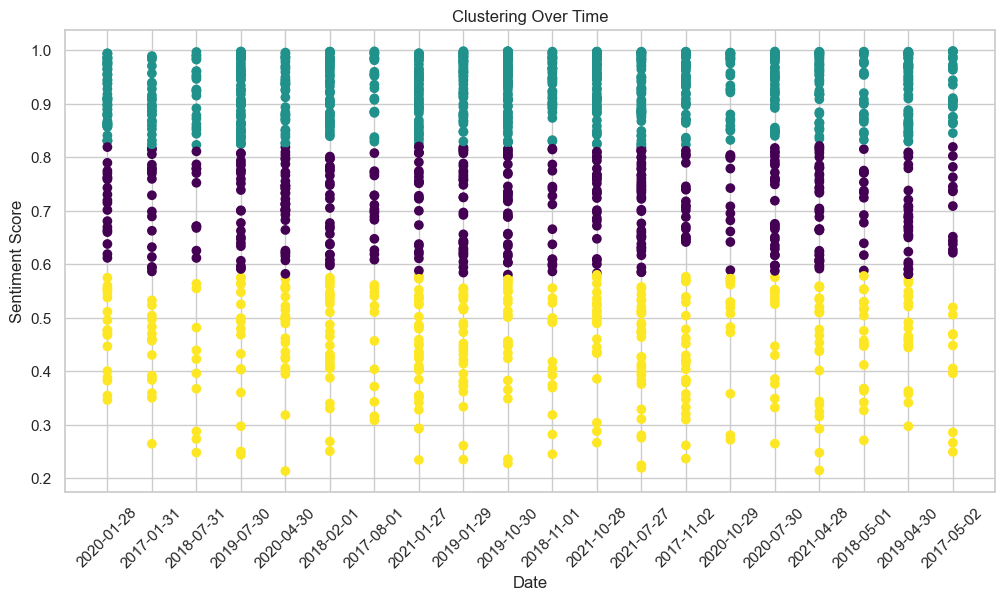

In [76]:
all_X = [all_companies_df[company_name][["mystery indicator", "VADER sentiment"]] for company_name in all_companies_df]

X = AAPL_df[["Sentiment Score"]]

# Using the KMeans clustering model with 3 clusters to determine if there are patterns
# Feel free to increase or decrease the number of clusters
kmeans = KMeans(n_clusters=3).fit(X)

AAPL_df["Clusters"] = kmeans.labels_

# Plots it
plt.figure(figsize=(12, 6))
# I'm not sure if date is the best plot to scatter on, will experiment with other factors such as classification
plt.scatter(AAPL_df["date"], AAPL_df["Sentiment Score"], c=AAPL_df["Clusters"], cmap="viridis")
plt.title("Clustering Over Time")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Sentiment Score")


## Additional Exploration: Wordcloud

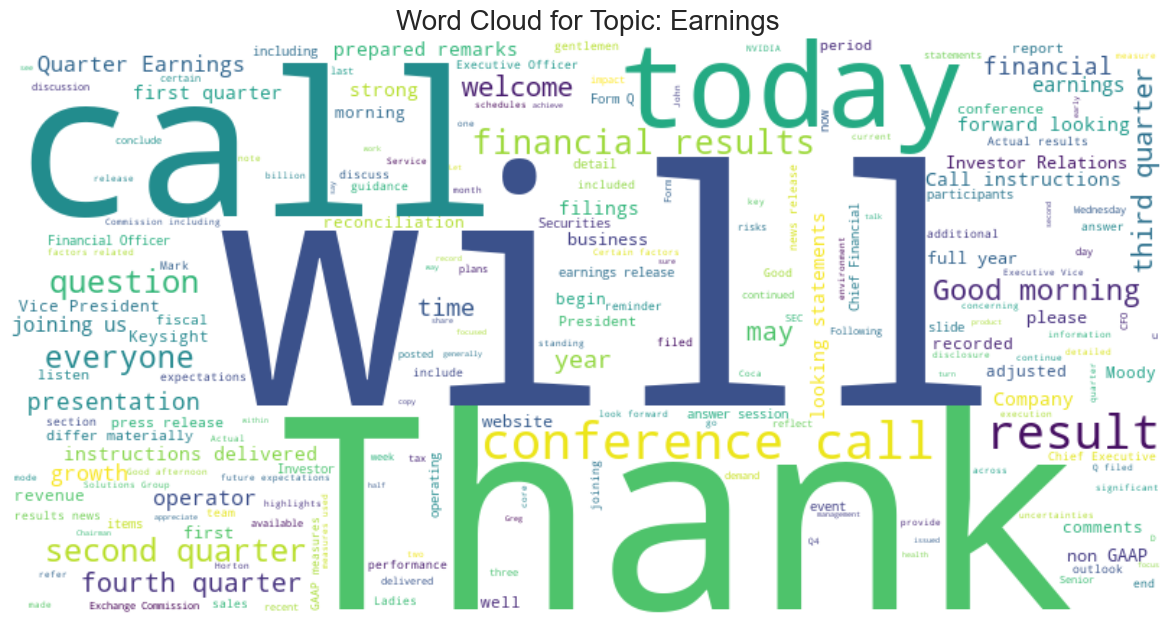

In [ ]:
from wordcloud import WordCloud

# Just an example
topic = 'Earnings'
text = ' '.join(df[df['extracted_topics'] == topic]['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Word Cloud for Topic: {topic}', fontsize=20)
plt.axis('off')
plt.show()


## Guidelines:

You are expected to work independently on this assignment.
You can consult online resources. Clearly indicate the resource that was consulted.
Indicate if you used the model to generate topics or used the dataset annotated with topics.
Make sure that your Notebook is well documented (commented).
